Detected Noise Level: HIGH — Applying 3 denoising iterations
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Denoised image saved to: /content/drive/MyDrive/SALT AND PEPPER/Noisy_folder/denoised_output.jpg


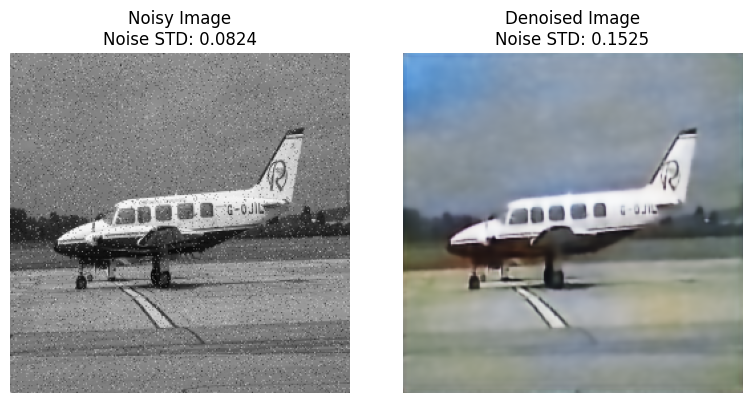

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load trained Deep U-Net model
model_path = '/content/drive/MyDrive/a_deeper_unet_model.keras'
model = load_model(model_path)

# Preprocess function
def preprocess_single_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dim
    return img

# Estimate noise level
def estimate_noise_level(img_tensor):
    # Convert from (1, H, W, 3) to (H, W, 3)
    img = img_tensor[0]
    noise_std = np.std(img)

    if noise_std < 0.03:
        return 'low', 1
    elif noise_std < 0.08:
        return 'medium', 2
    else:
        return 'high', 3

# Iterative Denoising
def iterative_denoising(image_tensor, steps=3):
    for _ in range(steps):
        image_tensor = model.predict(image_tensor)
    return image_tensor

# Inference Pipeline
def denoise_single_image(image_path, save_output=True):
    input_tensor = preprocess_single_image(image_path)

    # 🔍 Detect noise level
    noise_level, steps = estimate_noise_level(input_tensor)
    print(f"Detected Noise Level: {noise_level.upper()} — Applying {steps} denoising iterations")

    # 🧹 Denoise based on noise level
    denoised_tensor = iterative_denoising(input_tensor, steps=steps)[0]  # Remove batch dim
    original_tensor = input_tensor[0]

    # 📈 Approximate noise metrics
    std_before = np.std(original_tensor - denoised_tensor)
    std_after = np.std(denoised_tensor)

    # 🔻 Save output
    if save_output:
        output_path = os.path.join(os.path.dirname(image_path), "denoised_output.jpg")
        denoised_bgr = cv2.cvtColor((denoised_tensor * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, denoised_bgr)
        print(f"Denoised image saved to: {output_path}")

    # 🖼️ Plot input vs output
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_tensor)
    plt.title(f"Noisy Image\nNoise STD: {std_before:.4f}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_tensor)
    plt.title(f"Denoised Image\nNoise STD: {std_after:.4f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 🔧 Example usage
image_path = '/content/drive/MyDrive/SALT AND PEPPER/Noisy_folder/noisy_12988124424_18a549ee57_c.jpg'
denoise_single_image(image_path)


In [6]:
# Clone realESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

# Clone BSRGAN
!git clone https://github.com/cszn/BSRGAN.git

!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGAN.pth -P BSRGAN/model_zoo
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth -P experiments/pretrained_models

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 759 (delta 106), reused 98 (delta 98), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 32.78 MiB/s, done.
Resolving deltas: 100% (415/415), done.
/content/SwinIR/SwinIR/SwinIR/Real-ESRGAN
/usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.11/dist-packages/setuptools/command/develop.py:41: EasyI

In [7]:
import os
import glob
from google.colab import files
import shutil
print(' Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.\n Note2: You may need Chrome to enable file uploading!\n Note3: If out-of-memory, set test_patch_wise = True.\n')

# test SwinIR by partioning the image into patches
test_patch_wise = False

# to be compatible with BSRGAN
!rm -r BSRGAN/testsets/RealSRSet
upload_folder = 'BSRGAN/testsets/RealSRSet'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

 Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.
 Note2: You may need Chrome to enable file uploading!
 Note3: If out-of-memory, set test_patch_wise = True.



Saving denoised_output_5.jpg to denoised_output_5.jpg
Saving denoised_output_6.jpg to denoised_output_6.jpg
Saving denoised_output_7.jpg to denoised_output_7.jpg
move denoised_output_5.jpg to BSRGAN/testsets/RealSRSet/denoised_output_5.jpg
move denoised_output_6.jpg to BSRGAN/testsets/RealSRSet/denoised_output_6.jpg
move denoised_output_7.jpg to BSRGAN/testsets/RealSRSet/denoised_output_7.jpg


In [9]:
# BSRGAN
!rm -r results
if not test_patch_wise:
  # Change directory to BSRGAN to run its script
  %cd BSRGAN
  # Execute the BSRGAN test script
  !python main_test_bsrgan.py
  # Change back to the parent directory
  %cd ..

  # Define the expected path of the results created by the BSRGAN script
  bsrgan_results_path = 'BSRGAN/testsets/RealSRSet_results_x4'
  # Define the target path in the results directory
  target_bsrgan_path = 'results/BSRGAN'

  # Check if the BSRGAN results directory exists before attempting to move it
  if os.path.exists(bsrgan_results_path):
      # Move the BSRGAN results to the main results directory
      shutil.move(bsrgan_results_path, target_bsrgan_path)
      print(f"Moved BSRGAN results from {bsrgan_results_path} to {target_bsrgan_path}")
  else:
      # If the directory doesn't exist, print a warning
      print(f"Warning: BSRGAN results directory not found at {bsrgan_results_path}. Skipping move.")
      print("Please check the output of the BSRGAN script (main_test_bsrgan.py) for errors or unexpected output locations.")


# realESRGAN
if test_patch_wise:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN --tile 800
else:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN

# SwinIR
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --tile 800
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4
shutil.move('results/swinir_real_sr_x4', 'results/SwinIR')

# SwinIR-Large
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model --tile 640
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model
shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large')
for path in sorted(glob.glob(os.path.join('results/SwinIR_large', '*.png'))):
  os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png')) # here is a bug in Colab file downloading: no same-name files

rm: cannot remove 'results': No such file or directory
/content/SwinIR/SwinIR/SwinIR/Real-ESRGAN/BSRGAN
LogHandlers setup!
25-05-20 10:53:38.712 :       Model Name : BSRGAN
Traceback (most recent call last):
  File "/content/SwinIR/SwinIR/SwinIR/Real-ESRGAN/BSRGAN/main_test_bsrgan.py", line 123, in <module>
    main()
  File "/content/SwinIR/SwinIR/SwinIR/Real-ESRGAN/BSRGAN/main_test_bsrgan.py", line 63, in main
    logger.info('{:>16s} : {:<d}'.format('GPU ID', torch.cuda.current_device()))
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py", line 971, in current_device
    _lazy_init()
  File "/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py", line 319, in _lazy_init
    torch._C._cuda_init()
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
/content/SwinIR/Swi

In [10]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
import os
import glob
import shutil

def display(img1, img2):
  total_figs = 5
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title('Input image', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title('BSRGAN (ICCV2021) output', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title('Real-ESRGAN output', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title('SwinIR (ours) output', fontsize=30)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, total_figs, 5)
  plt.title('SwinIR-Large (ours) output', fontsize=30)
  ax5.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2['BSRGAN'])
  ax3.imshow(img2['realESRGAN'])
  ax4.imshow(img2['SwinIR'])
  ax5.imshow(img2['SwinIR-L'])

def imread(img_path):
  img = cv2.imread(img_path)
  # Check if image was loaded successfully before converting color space
  if img is None:
      print(f"Warning: Could not read image from {img_path}")
      return None # Return None if image reading fails
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
print('Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.')
if test_patch_wise:
  print('BSRGAN does not support "test_patch_wise" mode for now. Set test_patch_wise = False to see its results.\n')
else:
  print('\n')
input_folder = upload_folder
result_folder = 'results/SwinIR'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))

for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = {}
  img_output['SwinIR'] = imread(output_path)
  img_output['SwinIR-L'] = imread(output_path.replace('SwinIR/', 'SwinIR_large/').replace('SwinIR.png', 'SwinIR_large.png'))

  if test_patch_wise:
    # BSRGAN does not support patch-wise, so create a blank image
    if img_output['SwinIR'] is not None:
      img_output['BSRGAN'] = img_output['SwinIR']*0+255
    else:
      # If SwinIR image is also None, create a placeholder of a fixed size
      img_output['BSRGAN'] = (256, 256, 3)*0+255 # Example placeholder size
  else:
    img_output['BSRGAN'] = imread(output_path.replace('SwinIR', 'BSRGAN'))

  # Construct the intended final path for the realESRGAN image
  real_esrgan_original_path = output_path.replace('/SwinIR/', '/realESRGAN/').replace('_SwinIR.png','_out{}'.format(os.path.splitext(input_path)[1]))
  real_esrgan_final_path = real_esrgan_original_path.replace('_out.', '_realESRGAN.')

  # Move the file if it exists at the original path
  if os.path.exists(real_esrgan_original_path):
    shutil.move(real_esrgan_original_path, real_esrgan_final_path)

  # Read from the final path
  img_output['realESRGAN'] = imread(real_esrgan_final_path)

  # Only display if all images were loaded successfully
  if img_input is not None and img_output['SwinIR'] is not None and img_output['SwinIR-L'] is not None and img_output['BSRGAN'] is not None and img_output['realESRGAN'] is not None:
    display(img_input, img_output)
  else:
      print(f"Skipping display for input {input_path} due to image loading errors.")

Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.


Skipping display for input BSRGAN/testsets/RealSRSet/denoised_output_5.jpg due to image loading errors.
Skipping display for input BSRGAN/testsets/RealSRSet/denoised_output_6.jpg due to image loading errors.
Skipping display for input BSRGAN/testsets/RealSRSet/denoised_output_7.jpg due to image loading errors.


In [11]:
# Download the results
zip_filename = 'SwinIR_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>